# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
#all terms

import time
time_initial = time.time()


import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic

#heat data import
from deepymod.data.heat_data import heat_delta
import exp_heat_data

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cpu


# Dataset
Create all the argument we need to create a Burgers dataset:

In [2]:
# Making dataset
#v = 0.1
#A = 1.0
D = 1 #diffusion constant
noise = 0 #initially 0.05
num_samples = 1000 #initially 500
percent_train = 0.99 #initially 0.8
save = True
exp = True
filenum = 6
max_iters = 200000

x = torch.linspace(-3, 4, 100)
t = torch.linspace(0.5, 5.0, 50)
#load_kwargs = {"x": x, "t": t, "v": v, "A": A}
load_kwargs = {"x": x, "t": t, "D": D}
preprocess_kwargs = {"noise_level": noise}

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

Dataset is using device:  cpu
Dataset is using device:  cpu


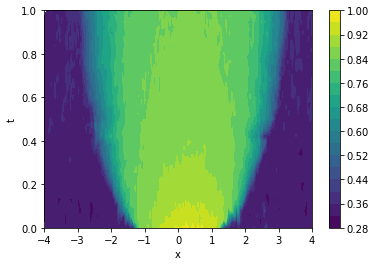

In [3]:
dataset = Dataset(
    exp_heat_data.exp_heat_delta, #heat_delta,#burgers_delta,   #actual data set
    load_kwargs=load_kwargs,     #variables for data?
    preprocess_kwargs=preprocess_kwargs,    #noise level
    subsampler=Subsample_random,    #sampler for getting training set
    subsampler_kwargs={"number_of_samples": num_samples},    #number of training samples to use
    device=device,    #device to save to?
)

dataset2 = Dataset(
    exp_heat_data.exp_heat_delta, #heat_delta,#burgers_delta,   #actual data set
    load_kwargs=load_kwargs,     #variables for data?
    preprocess_kwargs=preprocess_kwargs,    #noise level
    subsampler=Subsample_random,    #sampler for getting training set
    subsampler_kwargs={"number_of_samples": 5000},    #number of training samples to use
    device=device,    #device to save to?
)


coords = dataset2.get_coords().cpu()
data = dataset2.get_data().cpu()
fig, ax = plt.subplots()
im = plt.tricontourf(coords[:,1], coords[:,0], data[:,0], 20)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)


plt.show()

if save:
    if exp:
        fig.savefig("exp_fullSolution_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("fullSolution_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

Let's plot it to get an idea of the data. As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. We also added 5% of noise.

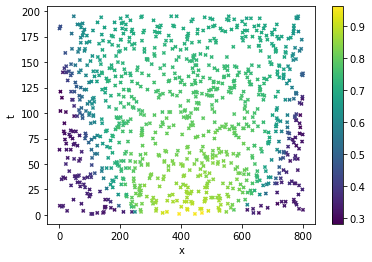

In [4]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

if save:
    if exp:
        fig.savefig("exp_sample_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("sample_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [5]:
train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=percent_train
)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [6]:
network = NN(2, [50, 50, 50,50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [7]:
library = Library1D(poly_order=2, diff_order=3, time_diff_order=0) 
#time diff order skips 1 and u_t (so 0 and 1 are both nothing)

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [8]:
estimator = Threshold(0.1) #initially 0.1
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [9]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and send it to the GPU and select the optimizer 

In [10]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set, the training and test loaders:
* The directory where the tensorboard file is written (log_dir)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [11]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    exp_ID="Test",
    write_iterations=25,
    max_iterations=max_iters, #initially 100000
    delta=1e-4,
    patience=200,
)

   250  MSE: 2.32e-02  Reg: 7.81e-08  L1: 3.07e+01 

KeyboardInterrupt: 

In [ ]:
model.sparsity_masks #says which coefficients in result are 0 (false) or non-zero (true)

estimatior_coeffs gives the magnitude of the active terms:

In [ ]:
#scaled coefficients
print(model.estimator_coeffs())

In [ ]:
#unscaled coefficients
print(model.constraint_coeffs(sparse=True, scaled=False))

NameError: name 'exp' is not defined

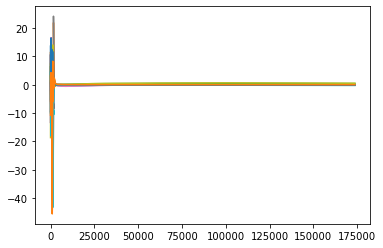

In [1]:

iter_list = np.genfromtxt("iter_list%i.txt" %filenum)
coeffs_list = np.genfromtxt("coeffs_list%i.txt" %filenum)

#print(iter_list)
#print(coeffs_list)
labels=("1","u_x","u_xx","u_xxx","u","uu_x","uu_xx","uu_xxx","u^2","u^2u_x","u^2u_xx","u^2u_xxx")
plt.clf()
i=0
while i < len(coeffs_list):
    plt.plot(iter_list, coeffs_list[i], label=labels[i])
    i=i+1
#plt.plot(iter_list, coeffs_list, label="u_xx")
#plt.legend(bbox_to_anchor=(1,1))
if save:
    if exp:
        plt.savefig("exp_coeffgraph_allterms%i" % filenum)
    else:
        plt.savefig("coeffgraph_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise))
#plt.show()

[-9.89467558e-03 -5.81445813e-01  1.59000963e-01 -2.63724416e-01
 -9.18931305e-01  7.64081299e-01  1.35699436e-02  7.40336275e+00
  6.85252953e+00 -1.31140833e+01  2.21075840e+01 -1.50354862e+01]


In [ ]:
learned_coords = torch.tensor(np.genfromtxt("learned_data_coords%i.txt" % filenum))
learned_data = torch.tensor(np.genfromtxt("learned_data_vals%i.txt" % filenum))

#f=open("learned_data_coords.txt", "w")
#f.write("")
#f.close()
#f=open("learned_data_vals.txt", "w")
#f.write("")
#f.close()
#print(f.read())


fig, ax = plt.subplots()
im = ax.scatter(learned_coords[:,1], learned_coords[:,0], c=learned_data, marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()
plt.close(fig)

if save:
    if exp:
        fig.savefig("exp_predictionScatter_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("predictionScatter_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#learned data for samples

fig, ax = plt.subplots()
im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], learned_data, 20)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()
plt.close(fig)

if save:
    if exp:
        fig.savefig("exp_prediction_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("prediction_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

In [ ]:
#actual data for samples
if not exp:
    fig, ax = plt.subplots()
    x=learned_coords[:,1]
    t=learned_coords[:,0]
    real_data = 1/((4*np.pi*t*D)**(1/2))*np.exp(-(x**2)/(4*D*t))
    im = plt.tricontourf(x, t, real_data, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("actual_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

In [ ]:
#error data
if not exp:
    error_data = real_data - learned_data

    fig, ax = plt.subplots()
    im = plt.tricontourf(x, t, error_data, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("error_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#learned u_x graph
learned_ux = torch.tensor(np.genfromtxt("learned_ux_vals%i.txt" % filenum))

fig, ax = plt.subplots()
im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], learned_ux, 20)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()
plt.close(fig)

if save:
    if exp:
        fig.savefig("exp_learnedux_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("learnedux_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

In [ ]:
#learned u_xx graph
learned_uxx = torch.tensor(np.genfromtxt("learned_uxx_vals%i.txt" % filenum))

fig, ax = plt.subplots()
im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], learned_uxx, 20)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()
plt.close(fig)

if save:
    if exp:
        fig.savefig("exp_learneduxx_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("learneduxx_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)

In [ ]:
#learned u_t graph
learned_ut = torch.tensor(np.genfromtxt("learned_ut_vals%i.txt" % filenum))

fig, ax = plt.subplots()
im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], learned_ut, 20)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()
plt.close(fig)

if save:
    if exp:
        fig.savefig("exp_learnedut_allterms%i.png" % filenum, transparent=True)
    else:
        fig.savefig("learnedut_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#actual u_x
if not exp:
    x=learned_coords[:,1]
    t=learned_coords[:,0]
    real_ux = (1/(4*np.pi*t*D)**(1/2)) * np.exp(-x**2 / (4*t*D)) * (-2*x / (4*D*t))

    fig, ax = plt.subplots()
    im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], real_ux, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("actual_ux_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#actual u_xx
if not exp:
    x=learned_coords[:,1]
    t=learned_coords[:,0]
    real_uxx = (1/(4*np.pi*t*D)**(1/2))*(-1/(4*D*t))*((2*np.exp(-x**2/(4*D*t))) + (4*(x**2)*np.exp(-x**2/(4*t*D))*(-1/(4*D*t))))

    fig, ax = plt.subplots()
    im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], real_uxx, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("actual_uxx_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#actual u_t
if not exp:
    x=learned_coords[:,1]
    t=learned_coords[:,0]
    real_ut = D * (1/(4*np.pi*t*D)**(1/2))*(-1/(4*D*t))*((2*np.exp(-x**2/(4*D*t))) + (4*(x**2)*np.exp(-x**2/(4*t*D))*(-1/(4*D*t))))

    fig, ax = plt.subplots()
    im = plt.tricontourf(learned_coords[:,1], learned_coords[:,0], real_ut, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("actual_ut_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#u_x error
if not exp:
    error_ux = real_ux - learned_ux

    fig, ax = plt.subplots()
    im = plt.tricontourf(x, t, error_ux, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("error_ux_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#u_xx error
if not exp:
    error_uxx = real_uxx - learned_uxx

    fig, ax = plt.subplots()
    im = plt.tricontourf(x, t, error_uxx, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("error_uxx_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


In [ ]:
#u_t error
if not exp:
    error_ut = real_ut - learned_ut

    fig, ax = plt.subplots()
    im = plt.tricontourf(x, t, error_ut, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    fig.colorbar(mappable=im)
    plt.show()
    plt.close(fig)

    if save:
        fig.savefig("error_ut_D%f_Size%i_Train%f_Noise%f.png" % (D, num_samples, percent_train, noise), transparent=True)


Sparsity masks provide the active and non-active terms in the PDE:

So the final terms that remain are the $u_{xx}$ and $u u_{x}$ resulting in the following Burgers equation (in normalized coefficients: 
$u_t = 0.4 u_{xx} - u u_{x}$.

In [ ]:
#f = open("heatResultData.txt", "a")
#f.write("*testing with time derivs*")
#f.write("D: %f, #Points: %f, Noise: %f, Train Percent: %f, Result: %s \n" % (D, num_samples, noise, percent_train, model.estimator_coeffs()))
#f.close()



Terms with time derivative: 1, u_t, u_tt, u_ttt, u, uu_t, uu_tt, uu_ttt, u^2, u^2u_t, u^2u_tt, u^2u_ttt

In [ ]:
time_elapsed = time.time() - time_initial
print(time_elapsed)

(12, 2851)


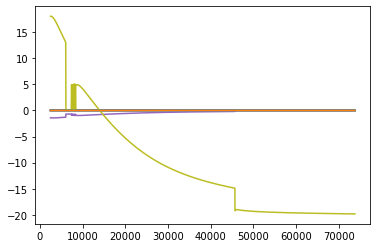

In [13]:
iter_list = np.genfromtxt("iter_list4.txt")[100:8000]
coeffs_list = np.genfromtxt("coeffs_list4.txt")[:,100:8000]
print(coeffs_list.shape)
plt.clf()
i=0
while i < len(coeffs_list):
    plt.plot(iter_list, coeffs_list[i])
    i=i+1